## **CPC251 Project Part 1 - Cancer4**

#### Instruction (Read this)
- Use this template to develop your project. Do not change the steps. 
- For each step, you may add additional cells if needed.
- But remove <b>unnecessary</b> cells to ensure the notebook is readable.
- Marks will be <b>deducted</b> if the notebook is cluttered or difficult to follow due to excess or irrelevant content.
- <b>Briefly</b> describe the steps in the "Description:" field.
- <b>Do not</b> submit the dataset. 
- The submitted jupyter notebook will be executed using the uploaded dataset in eLearn.

#### **Group Information**

Group No: 

- Member 1: Ooi Zhun Shen
- Member 2: Teh Juin Ewe
- Member 3: Khor Jun Hao
- Member 4: Wong Xin Ru


#### **Import libraries**

In [53]:
%config Completer.use_jedi=False # comment if not needed

# Import necessary libraries for data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # Disable warning output

# Import libraries for preprocessing, modeling, and evaluation
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Install and import library for handling imbalanced datasets
%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE # for oversampling
from collections import Counter # for counting class distribution

Note: you may need to restart the kernel to use updated packages.


#### **Load the dataset**

Based on the 5 sample below, it can be observed that the dataset is categorized into  demographic features (e.g. age), behavioral factors (e.g. number of sexual partners, smoking), and medical history (e.g. contraceptive use, STDs, diagnosis).

Some **missing values can be identified** inside the columns of the dataset.

In [54]:
df = pd.read_csv('D:/Documents/Cervical Cancer/risk_factors.csv', na_values='?') # Load the dataset
df.sample(5) # Display a random sample of 5 rows from the dataset


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
434,20,3.0,17.0,2.0,0.0,0.0,0.0,1.0,0.25,0.0,...,NaN,NaN,0,0,0,0,0,0,1,1
355,19,3.0,13.0,4.0,0.0,0.0,0.0,0.0,0.00,0.0,...,6.0,6.0,0,0,0,0,0,0,0,0
596,18,1.0,18.0,1.0,0.0,0.0,0.0,1.0,0.08,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
513,18,2.0,17.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
154,27,2.0,15.0,3.0,0.0,0.0,0.0,1.0,6.00,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


The dataset contains **858 total entries and 36 columns**.

In [55]:
# Summarize the dataset
df.info() # Display information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

This code summarizes the number of missing values for each feature in the dataset. It helps identify columns with high missing rates that may require imputation or removal during preprocessing.

In [56]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False) # Display the count of missing values in each column

STDs: Time since last diagnosis       787
STDs: Time since first diagnosis      787
IUD                                   117
IUD (years)                           117
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
STDs:pelvic inflammatory disease      105
STDs:vulvo-perineal condylomatosis    105
STDs:HPV                              105
STDs:Hepatitis B                      105
STDs:HIV                              105
STDs:AIDS                             105
STDs:molluscum contagiosum            105
STDs:genital herpes                   105
STDs:syphilis                         105
STDs:vaginal condylomatosis           105
STDs:cervical condylomatosis          105
STDs:condylomatosis                   105
STDs (number)                         105
STDs                                  105
Num of pregnancies                     56
Number of sexual partners              26
Smokes (packs/year)                    13
Smokes (years)                    

##### Checking for Mismatches

* **Ensure semantic consistency:** By verifying that whenever a Boolean flag is “Yes” the corresponding count or duration isn’t missing, and whenever it’s “No” the count/duration isn’t positive, we confirm that the two columns truly pair up as presence ↔ quantity.

* **Validate main‐flag integrity:** Checking that no specific-STD flag is raised when the overall STDs flag is 0 guarantees there are no hidden contradictions in the data.

* **Prevent misleading imputations:** If any of these mismatches existed, blindly filling NaNs with zero could produce implausible “no history” signals for patients who actually did have a condition (or vice versa).



In [57]:
# Pairs of (flag, count)
pairs = [
    ("Smokes", "Smokes (years)"),
    ("Smokes", "Smokes (packs/year)"),
    ("Hormonal Contraceptives", "Hormonal Contraceptives (years)"),
    ("IUD", "IUD (years)")
]


std_specific_flags = [
    "STDs:condylomatosis",
    "STDs:cervical condylomatosis",
    "STDs:vaginal condylomatosis",
    "STDs:vulvo-perineal condylomatosis",
    "STDs:syphilis",
    "STDs:pelvic inflammatory disease",
    "STDs:genital herpes",
    "STDs:molluscum contagiosum",
    "STDs:AIDS",
    "STDs:HIV",
    "STDs:Hepatitis B",
    "STDs:HPV"
]

def check_flag_count(flag, count_col):
    # Flag = 1 but count is missing
    mask1 = (df[flag] == 1) & (df[count_col].isna())
    print(f"{flag}=1 but {count_col} is NaN: {mask1.sum()} rows")

    # Flag = 0 but count > 0
    mask2 = (df[flag] == 0) & (df[count_col].fillna(0) > 0)
    print(f"{flag}=0 but {count_col} > 0: {mask2.sum()} rows")


# Any specific‐STD flag = 1 ⇒ STDs main flag = 1?
for col in std_specific_flags:
    mask = (df[col] == 1) & (df["STDs"] == 0)
    print(col, "mismatch count:", mask.sum())
    
print("\n")

for flag, count in pairs:
    check_flag_count(flag, count)

STDs:condylomatosis mismatch count: 0
STDs:cervical condylomatosis mismatch count: 0
STDs:vaginal condylomatosis mismatch count: 0
STDs:vulvo-perineal condylomatosis mismatch count: 0
STDs:syphilis mismatch count: 0
STDs:pelvic inflammatory disease mismatch count: 0
STDs:genital herpes mismatch count: 0
STDs:molluscum contagiosum mismatch count: 0
STDs:AIDS mismatch count: 0
STDs:HIV mismatch count: 0
STDs:Hepatitis B mismatch count: 0
STDs:HPV mismatch count: 0


Smokes=1 but Smokes (years) is NaN: 0 rows
Smokes=0 but Smokes (years) > 0: 0 rows
Smokes=1 but Smokes (packs/year) is NaN: 0 rows
Smokes=0 but Smokes (packs/year) > 0: 0 rows
Hormonal Contraceptives=1 but Hormonal Contraceptives (years) is NaN: 0 rows
Hormonal Contraceptives=0 but Hormonal Contraceptives (years) > 0: 0 rows
IUD=1 but IUD (years) is NaN: 0 rows
IUD=0 but IUD (years) > 0: 0 rows


Logical consistency checks were performed between indicator flags (e.g., Smokes, IUD) and their corresponding duration/count columns.

No mismatches were found, confirming that the presence flags align with their values. The STDs flag also matched all specific STD indicators, ensuring data integrity for modeling.

1. Dropping the two `time since diagnosis` columns **(≈92% missing)**

2. Imputing 0 for all Boolean flags.

3. Imputing median for the remaining truly numeric columns with moderate missingness


In [58]:
# 1. Drop the two “time since diagnosis” columns with ~92% missing
df = df.drop(columns=[
    "STDs: Time since first diagnosis",
    "STDs: Time since last diagnosis"
])

# 2. Zero-fill Boolean flags and their count/duration partners
bool_and_count_cols = [
    "Smokes", "Smokes (years)", "Smokes (packs/year)",
    "Hormonal Contraceptives", "Hormonal Contraceptives (years)",
    "IUD", "IUD (years)",
    "STDs", "STDs (number)",
    "STDs:condylomatosis", "STDs:cervical condylomatosis",
    "STDs:vaginal condylomatosis", "STDs:vulvo-perineal condylomatosis",
    "STDs:syphilis", "STDs:pelvic inflammatory disease",
    "STDs:genital herpes", "STDs:molluscum contagiosum",
    "STDs:AIDS", "STDs:HIV", "STDs:Hepatitis B", "STDs:HPV"
]

imp_zero = SimpleImputer(strategy="constant", fill_value=0)
df[bool_and_count_cols] = imp_zero.fit_transform(df[bool_and_count_cols])

# 3. Median-impute the remaining numeric columns
numeric_cols = [
    "Age",
    "Number of sexual partners",
    "First sexual intercourse",
    "Num of pregnancies"
]

imp_median = SimpleImputer(strategy="median")
df[numeric_cols] = imp_median.fit_transform(df[numeric_cols])

# Verify that no NaNs remain
print("Total missing values after imputation:", df.isna().sum().sum())


Total missing values after imputation: 0


In [59]:
# Set target variable
label = "Biopsy"
df[label].value_counts() # Display the count of each class in the target variable

Biopsy
0    803
1     55
Name: count, dtype: int64

The target variable `Biopsy` was analyzed using normalized value counts. It was found that the dataset is highly imbalanced, with approximately **93.6% of samples** labeled as `0` (no biopsy) and **only 6.4%** labeled as `1` (positive biopsy).

A correlation heatmap was generated using Pearson correlation coefficients (excluding the Biopsy column) to explore relationships between features.

Biopsy
0    0.935897
1    0.064103
Name: proportion, dtype: float64


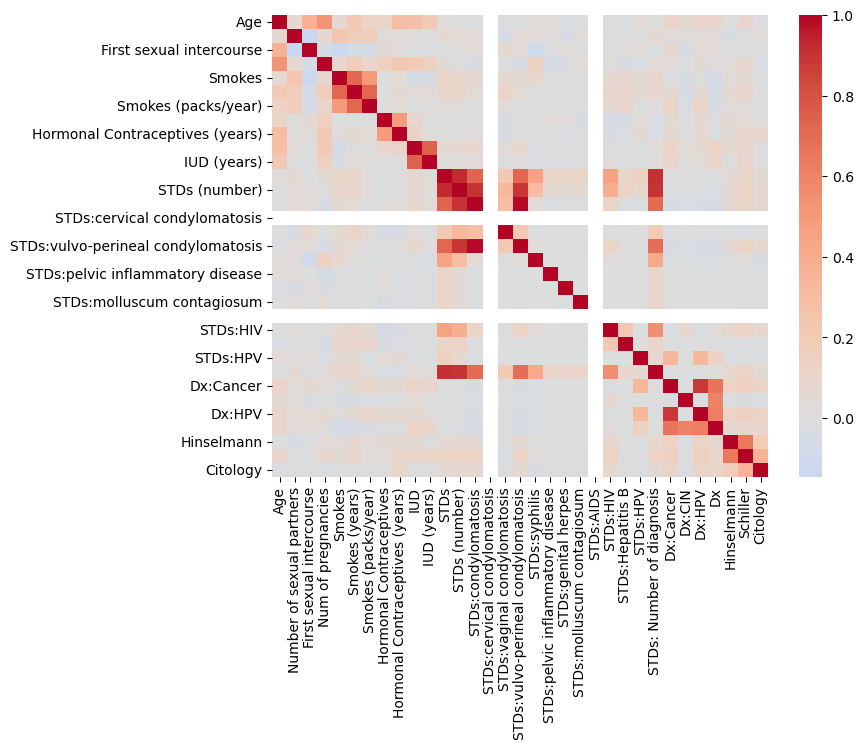

In [60]:
# 1. Target balance
print(df["Biopsy"].value_counts(normalize=True))

# 2. Simple correlations
corr = df.drop("Biopsy", axis=1).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()


In [61]:
# Count exact duplicates (all columns identical)
dup_count = df.duplicated().sum()
print(f"Exact duplicate rows: {dup_count}")

Exact duplicate rows: 38


Duplicate rows were removed from the dataset, retaining only the first occurrence to ensure data integrity.

In [62]:
df.drop_duplicates(keep="first", inplace=True)

The final dataset consists of **820 rows and 34 columns** after cleaning steps were completed.

In [63]:
df.reset_index(drop=True, inplace=True) # Reset the index after dropping duplicates
df.tail() # Display the last 5 rows of the DataFrame

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
815,34.0,3.0,18.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0,0,0,0,0,0,0,0,0
816,32.0,2.0,19.0,1.0,0.0,0.0,0.0,1.0,8.00,0.0,...,0.0,0,0,0,0,0,0,0,0,0
817,25.0,2.0,17.0,0.0,0.0,0.0,0.0,1.0,0.08,0.0,...,0.0,0,0,0,0,0,0,0,1,0
818,33.0,2.0,24.0,2.0,0.0,0.0,0.0,1.0,0.08,0.0,...,0.0,0,0,0,0,0,0,0,0,0
819,29.0,2.0,20.0,1.0,0.0,0.0,0.0,1.0,0.50,0.0,...,0.0,0,0,0,0,0,0,0,0,0


In [64]:
df.shape # Display the shape of the DataFrame

(820, 34)

#### **Split the dataset**

Split the dataset into training, validation and test sets.

The dataset was split into three subsets: **70% for training, 10% for validation, and 20% for testing**, using stratified sampling to maintain the original class distribution.

In [65]:
# Split the dataset into training, validation, and test sets
# Training : Validation : Test = 7 : 1 : 2

# 1. Features & target
X = df.drop("Biopsy", axis=1)
y = df["Biopsy"].astype(int)

# 2. Split the dataset into training and test sets
#    test_size = 0.2 as (training dataset + validation dataset) : test dataset = 8 : 2
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.20,      # 20% of the original data
    stratify=y,
    random_state=42
)

# 3. Of the remaining 80%, take 10% of the ORIGINAL as VALIDATION.
#    test_size = 0.125 as training dataset : validation dataset = 7 : 1
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,     # 0.125 * 80% = 10% of original
    stratify=y_temp,
    random_state=42
)

# 4. Verify the splits
print("Train  (≈70%):", X_train.shape, y_train.value_counts(normalize=True).to_dict())
print("Valid  (≈10%):", X_val.shape,   y_val.value_counts(normalize=True).to_dict())
print("Test   (≈20%):", X_test.shape,  y_test.value_counts(normalize=True).to_dict())

Train  (≈70%): (574, 33) {0: 0.9337979094076655, 1: 0.06620209059233449}
Valid  (≈10%): (82, 33) {0: 0.9390243902439024, 1: 0.06097560975609756}
Test   (≈20%): (164, 33) {0: 0.9329268292682927, 1: 0.06707317073170732}


#### **Data preprocessing**

Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________________________________________________________________
Description: The dataset underwent several preprocessing steps to prepare it for modeling.

Features with constant values were removed, and numerical features were standardized using `StandardScaler` to ensure consistent scale across models. Stratified splitting was applied to preserve class distribution across training, validation, and test sets. Additionally, `SMOTE` was used to oversample the minority class in the training set, addressing class imbalance for improved model learning.

In [66]:
# Find columns with only one unique value (zero variance)
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
print("Constant columns to drop:", constant_cols)

# Drop them
X_train.drop(columns=constant_cols, inplace=True)
X_val.drop(columns=constant_cols, inplace=True)
X_test .drop(columns=constant_cols, inplace=True)

# Save correct feature names before scaling and SMOTE
final_feature_names = X_train.columns

Constant columns to drop: ['STDs:cervical condylomatosis', 'STDs:AIDS']


Columns with zero variance (i.e., containing only a single unique value) were identified and removed from all datasets, as they do not provide any discriminatory power or useful information for model training.

In [67]:
# 1. Instantiate the scaler
scaler = StandardScaler()

# 2. Fit the scaler on the training data
scaler.fit(X_train)

# 3. Transform train, val, and test features
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

The target variable `Biopsy` was found to be **highly imbalanced**, with approximately **93.4% of the samples labeled as `0`** and only **6.6% labeled as `1`**.

In [68]:
print(df["Biopsy"].value_counts())
print(df["Biopsy"].value_counts(normalize=True))

Biopsy
0    766
1     54
Name: count, dtype: int64
Biopsy
0    0.934146
1    0.065854
Name: proportion, dtype: float64


##### Oversampling

`SMOTE` (Synthetic Minority Over-sampling Technique) was applied to the training set to balance the class distribution by generating synthetic samples for the minority class. This helps improve the model’s ability to learn from underrepresented cases, resulting in a balanced distribution of 536 samples for each class.

In [37]:
# Apply SMOTE to scaled training features only
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Print class distributions for confirmation
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 536, 1: 38})
After SMOTE: Counter({0: 536, 1: 536})


#### **Feature Selection**
Perform feature selection to select the relevant features.
______________________________________________________________________________________
Description: Feature selection was performed using `SelectKBest` with mutual information to retain the most relevant features.

This reduces dimensionality and helps improve model performance by removing less informative variables.

The same selection was consistently applied to the validation and test sets to ensure alignment.

In [38]:
# Fit SelectKBest on balanced, scaled training data (after SMOTE)
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_kbest = selector.fit_transform(X_train_resampled, y_train_resampled)

# Transform validation and test sets (which are scaled but NOT resampled)
X_val_kbest  = selector.transform(X_val_scaled)
X_test_kbest = selector.transform(X_test_scaled)

The top 10 features were selected based on mutual information scores, and their importance was visualized in a bar chart to highlight which variables contributed most to the prediction of biopsy outcomes.

In [ ]:
# Get all feature names and their scores
all_feature_names = final_feature_names
all_scores = selector.scores_

feature_importances = pd.DataFrame({
    "feature": all_feature_names,
    "importance": all_scores
}).sort_values("importance", ascending=False)


Selected features (Mutual Information): ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'Hinselmann', 'Schiller', 'Citology']


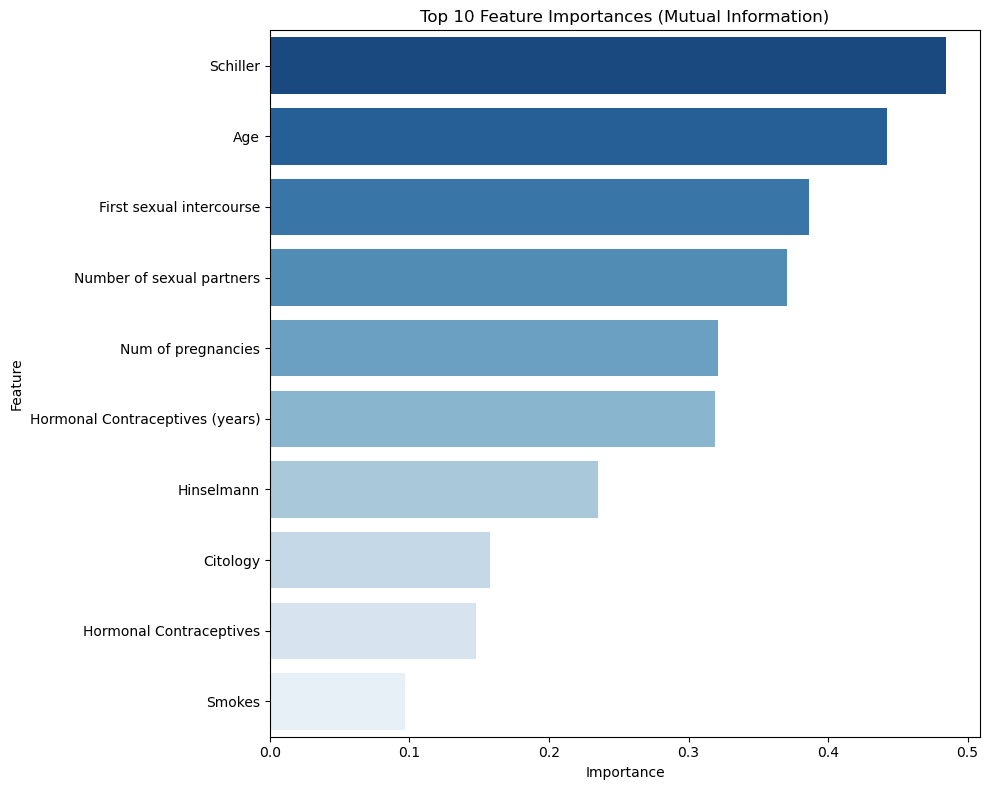

In [70]:
# Get the names of the selected features
selected_features = np.array(final_feature_names)[selector.get_support()]
print("Selected features (Mutual Information):", selected_features.tolist())

# Assuming feature_importances is already sorted descending by 'importance'
top_n = 10
top_features = feature_importances.head(top_n)

plt.figure(figsize=(10, 0.6 * top_n + 2))  # Dynamically adjust height
sns.barplot(x="importance", y="feature", data=top_features, palette="Blues_r")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances (Mutual Information)")
plt.tight_layout()
plt.show()

#### **Data modeling**
Build the machine learning models. You must build atleast two (2) predictive models. One of the predictive models must be either Decision Tree or Support Vector Machine.
______________________________________________________________________________________
Description: Two predictive models were developed: `Logistic Regression (LR)` and `Decision Tree Classifier (DTC)`.

Both models were trained on the preprocessed and balanced dataset, with **hyperparameter tuning performed** using `GridSearchCV` to optimize performance.

Model evaluation was based on accuracy, precision, recall, and F1-score using the test set.

A Repeated `Stratified K-Fold Cross-Validation` strategy was configured with 5 splits and 5 repetitions to ensure robust model evaluation while maintaining class distribution in each fold.

In [90]:
# Repeated Stratified K-Fold Cross-Validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

`plot_confusion_matrices_side_by_side()` function visualizes and compares the confusion matrices of a model before and after hyperparameter tuning by displaying them side by side. It helps assess how tuning has affected the model’s prediction accuracy across classes.

In [91]:
def plot_confusion_matrices_side_by_side(y_true, y_pred_default, y_pred_optimized, model_name):
    """
    Plot confusion matrices for two models side by side
    """
    cm_default = confusion_matrix(y_true, y_pred_default)
    cm_optimized = confusion_matrix(y_true, y_pred_optimized)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Default model
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - Default {model_name}')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Optimized model
    sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - Optimized {model_name}')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

Performance metrics including **accuracy, precision, recall, and F1 score** were computed for both the default and optimized models. These scores were visualized in a grouped bar chart to facilitate direct comparison. Each metric was annotated to clearly show the performance gain or loss achieved through optimization.

In [92]:
def plot_model_comparison(y_true, y_pred_default, y_pred_optimized, model_name="Model"):
    """
    Plot a bar chart comparing performance metrics between default and optimized models.

    Parameters:
        y_true           : True labels
        y_pred_default   : Predictions from the default model
        y_pred_optimized : Predictions from the optimized model
        model_name       : Full name for the titlE
    """
    # Metrics to compare
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Scores for default model
    default_scores = [
        accuracy_score(y_true, y_pred_default),
        precision_score(y_true, y_pred_default),
        recall_score(y_true, y_pred_default),
        f1_score(y_true, y_pred_default)
    ]

    # Scores for optimized model
    optimized_scores = [
        accuracy_score(y_true, y_pred_optimized),
        precision_score(y_true, y_pred_optimized),
        recall_score(y_true, y_pred_optimized),
        f1_score(y_true, y_pred_optimized)
    ]

    # Bar plot
    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, default_scores, width, label='Default ', color='navy')
    bars2 = ax.bar(x + width/2, optimized_scores, width, label='Optimized ', color='mediumpurple')

    # Labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'Performance Comparison of Default vs Optimized {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Annotate values on bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

This `evaluate_model_on_validation()` function evaluates a model's predictions on the validation set by printing key classification metrics, including accuracy, precision, recall, F1-score, and the confusion matrix. It provides a quick performance summary to assess how well the model generalizes before final testing.

In [93]:
def evaluate_model_on_validation(y_true, y_pred):
    """
    Display evaluation metrics for predictions on the validation set.

    Parameters:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
        model_name (str): Name of the model being evaluated
    """
    print(f"\nPerformance Summary")
    print("────────────────────────────────────────────")
    print(f"Accuracy        : {accuracy_score(y_true, y_pred):.6f}")
    print(f"Precision       : {precision_score(y_true, y_pred):.6f}")
    print(f"Recall          : {recall_score(y_true, y_pred):.6f}")
    print(f"F1 Score        : {f1_score(y_true, y_pred):.6f}")

    print("\nConfusion Matrix")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Breakdown")
    print(classification_report(y_true, y_pred))

In [94]:
def plot_roc_curve(model, X_val, y_val, model_name="Model"):
    """
    Plot ROC curve for a binary classifier using validation data.
    
    Parameters:
        model: trained classifier with .predict_proba()
        X_val: validation feature set
        y_val: true labels
        model_name: label to use in plot title
    """
    # Get predicted probabilities for the positive class (class 1)
    y_scores = model.predict_proba(X_val)[:, 1]

    # Compute FPR, TPR, and AUC
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random baseline")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve — {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### **Logistic Regression (LR)**

An instance of LR with default parameters

In [95]:
# Initialize the Logistic Regression model
lr_default = LogisticRegression(solver="liblinear", random_state=42)

# Fit the model on the training data
lr_default.fit(X_train_kbest, y_train_resampled)

# Make predictions on the validation set
y_val_pred_lr = lr_default.predict(X_val_kbest)

# Evaluate the model on the validation set
print("\nLogistic Regression (Default Parameters)")
evaluate_model_on_validation(y_val, y_val_pred_lr)


Logistic Regression (Default Parameters)

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.951220
Precision       : 0.571429
Recall          : 0.800000
F1 Score        : 0.666667

Confusion Matrix
[[74  3]
 [ 1  4]]

Classification Breakdown
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        77
           1       0.57      0.80      0.67         5

    accuracy                           0.95        82
   macro avg       0.78      0.88      0.82        82
weighted avg       0.96      0.95      0.95        82



Hyperparameter Tuning using **GridSearch CV** for LR

In [96]:
# Define parameter grid
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],   # Regularization strength (lower = stronger)
    'penalty': ['l1', 'l2'],               # Type of regularization
    'solver': ['saga']                     # Only solver that supports both l1 and l2
}

# Set up GridSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid=lr_param_grid,
    scoring='f1',     # Focus on improving F1 score for imbalanced data
    cv=cv,
    n_jobs=-1
)

# Fit the model on the training data
grid_search_lr.fit(X_train_kbest, y_train_resampled)

# Output the best parameters
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

# Predict on validation set using the best model
y_val_pred_lr_optimized = grid_search_lr.best_estimator_.predict(X_val_kbest)
evaluate_model_on_validation(y_val, y_val_pred_lr_optimized)

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.963415
Precision       : 0.666667
Recall          : 0.800000
F1 Score        : 0.727273

Confusion Matrix
[[75  2]
 [ 1  4]]

Classification Breakdown
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        77
           1       0.67      0.80      0.73         5

    accuracy                           0.96        82
   macro avg       0.83      0.89      0.85        82
weighted avg       0.97      0.96      0.96        82



In [97]:
results_lr_df = pd.DataFrame(grid_search_lr.cv_results_)
results_lr_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(
    by=['rank_test_score', 'mean_test_score'],
    ascending=[True, False]
).head(10)


,params,mean_test_score,rank_test_score
8,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.942127,1
9,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.942127,1
10,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.942127,1
11,"{'C': 100, 'penalty': 'l2', 'solver': 'saga'}",0.942127,1
7,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.939150,5
6,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.938131,6
5,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",0.935004,7
4,"{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}",0.932811,8
2,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.930778,9
3,"{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}",0.927664,10


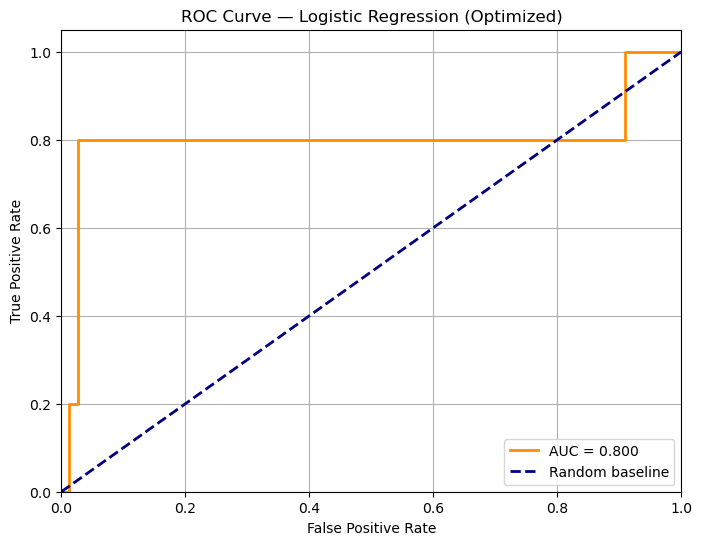

In [98]:
plot_roc_curve(
    grid_search_lr.best_estimator_,
    X_val_kbest,
    y_val,
    model_name="Logistic Regression (Optimized)"
)

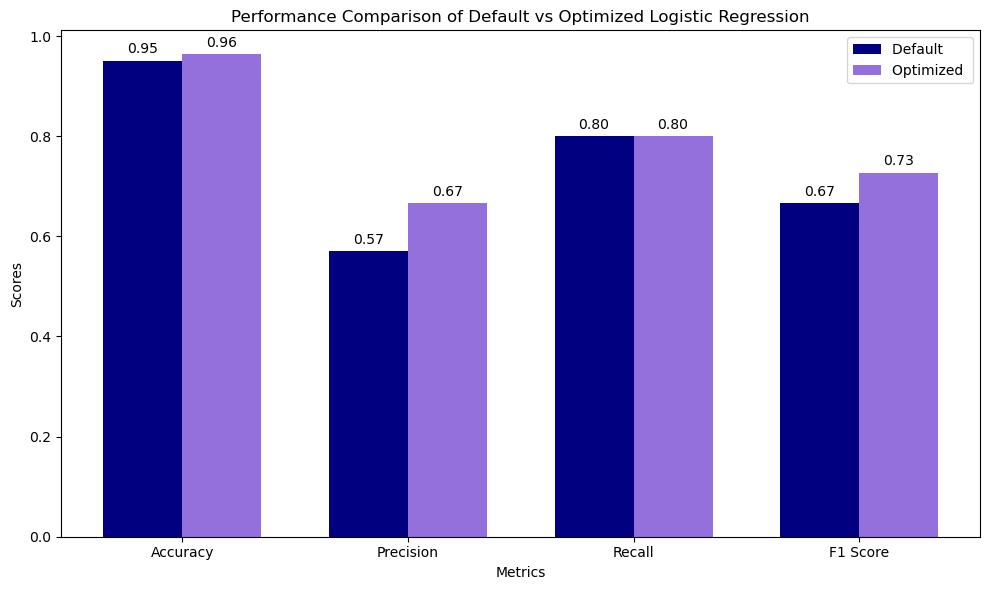

In [99]:
plot_model_comparison(
    y_true=y_val,
    y_pred_default=y_val_pred_lr,
    y_pred_optimized=y_val_pred_lr_optimized,
    model_name="Logistic Regression"
)

### **Decision Tree Classifier (DTC)**

An instance of DTC with default parameters

In [100]:
# Intialize the Decision Tree Classifier
dtc_default = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dtc_default.fit(X_train_kbest, y_train_resampled)

# Make predictions on the validation set
y_val_pred_dtc = dtc_default.predict(X_val_kbest)

# Evaluate the model on the validation set
print("\nDecision Tree Classifier (Default Parameters)")
evaluate_model_on_validation(y_val, y_val_pred_dtc)


Decision Tree Classifier (Default Parameters)

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.926829
Precision       : 0.333333
Recall          : 0.200000
F1 Score        : 0.250000

Confusion Matrix
[[75  2]
 [ 4  1]]

Classification Breakdown
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        77
           1       0.33      0.20      0.25         5

    accuracy                           0.93        82
   macro avg       0.64      0.59      0.61        82
weighted avg       0.91      0.93      0.92        82



Hyperparameter Tuning using **GridSearchCV** for DTC

In [101]:
# Define parameter grid
dt_param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42)

grid_search_dtc = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the model on the training data
grid_search_dtc.fit(X_train_kbest, y_train_resampled)

# Output the best parameters
print("Best parameters for Decision Tree Classifier:", grid_search_dtc.best_params_)

# Predict on validation set using the best model
y_val_pred_dtc_optimized = grid_search_dtc.best_estimator_.predict(X_val_kbest)
evaluate_model_on_validation(y_val, y_val_pred_dtc_optimized)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters for Decision Tree Classifier: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.939024
Precision       : 0.500000
Recall          : 0.400000
F1 Score        : 0.444444

Confusion Matrix
[[75  2]
 [ 3  2]]

Classification Breakdown
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        77
           1       0.50      0.40      0.44         5

    accuracy                           0.94        82
   macro avg       0.73      0.69      0.71        82
weighted avg       0.93      0.94      0.94        82



In [102]:
# Summary of top 10 hyperparameter combinations
top_dtc_configs = pd.DataFrame(grid_search_dtc.cv_results_)
top_dtc_configs[['params', 'mean_test_score', 'rank_test_score']].sort_values(
    by=['rank_test_score', 'mean_test_score'],
    ascending=[True, False]
).head(10)

,params,mean_test_score,rank_test_score
19,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.964410,1
63,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.962920,2
18,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.960752,3
27,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.960567,4
36,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.960567,4
72,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.960034,6
81,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.960034,6
21,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.959404,8
20,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.958641,9
9,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.958547,10


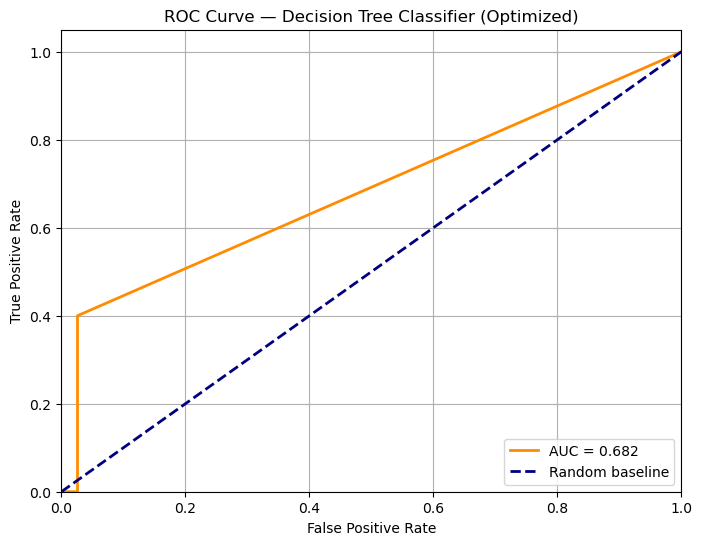

In [103]:
# Plot ROC curve for Decision Tree Classifier
plot_roc_curve(
    grid_search_dtc.best_estimator_,
    X_val_kbest,
    y_val,
    model_name="Decision Tree Classifier (Optimized)"
)

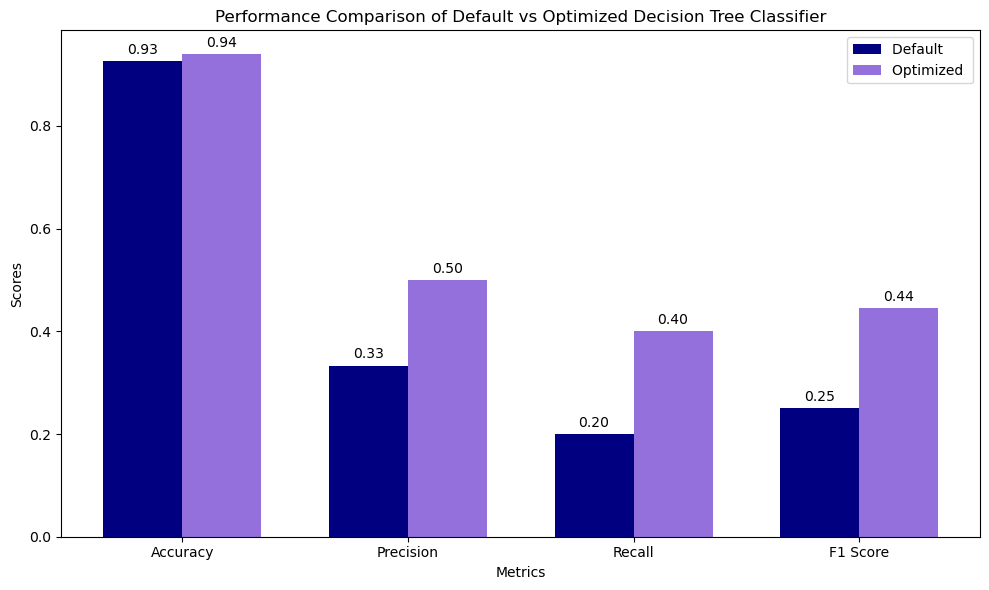

In [104]:
# Plot comparison of default and optimized models
plot_model_comparison(
    y_true=y_val,
    y_pred_default=y_val_pred_dtc,
    y_pred_optimized=y_val_pred_dtc_optimized,
    model_name="Decision Tree Classifier"
)

#### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
Report the R2 score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________
Description:

In [105]:
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Macro Precision': report['macro avg']['precision'],
        'Macro Recall': report['macro avg']['recall'],
        'Macro F1 Score': report['macro avg']['f1-score'],
        'Weighted Precision': report['weighted avg']['precision'],
        'Weighted Recall': report['weighted avg']['recall'],
        'Weighted F1 Score': report['weighted avg']['f1-score'],
    }
    return metrics

def compare_models(y_true, model_preds, model_names):
    metrics_list = []
    for pred, name in zip(model_preds, model_names):
        metrics_list.append(evaluate_model(y_true, pred, name))

    comparison_df = pd.DataFrame(metrics_list)

    # Plot confusion matrices
    fig, axes = plt.subplots(1, len(model_preds), figsize=(6 * len(model_preds), 4))
    if len(model_preds) == 1:
        axes = [axes]

    for i, (pred, name) in enumerate(zip(model_preds, model_names)):
        cm = confusion_matrix(y_true, pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {name}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

    # Plot Weighted Metrics
    metrics_to_plot = ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score']
    _plot_bar_chart(comparison_df, metrics_to_plot, "Model Comparison (Weighted Average)")

    # Plot Macro Metrics
    metrics_to_plot = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1 Score']
    _plot_bar_chart(comparison_df, metrics_to_plot, "Model Comparison (Macro Average)")

    # Print detailed classification reports
    for pred, name in zip(model_preds, model_names):
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_true, pred, zero_division=0))

    return comparison_df

def _plot_bar_chart(df, metrics, title):
    plt.figure(figsize=(15, 8))
    x = np.arange(len(metrics))
    width = 0.25

    for i, row in df.iterrows():
        plt.bar(x + i * width - width, [row[m] for m in metrics], width, label=row['Model'])

    for i, row in df.iterrows():
        for j, m in enumerate(metrics):
            plt.annotate(f"{row[m]:.4f}",
                         xy=(x[j] + i * width - width, row[m]),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, metrics)
    plt.legend()
    plt.tight_layout()
    plt.show()


Logistic Regression (LR)

In [106]:
y_pred_lr_test = grid_search_lr.best_estimator_.predict(X_test_kbest)

Decision Tree Classifier (DTC)

In [88]:
y_pred_dt_test = grid_search_dtc.best_estimator_.predict(X_test_kbest)

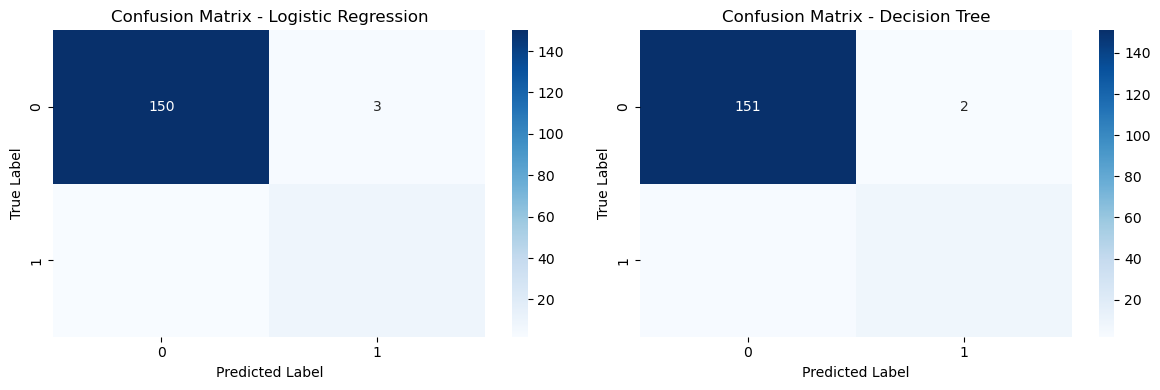

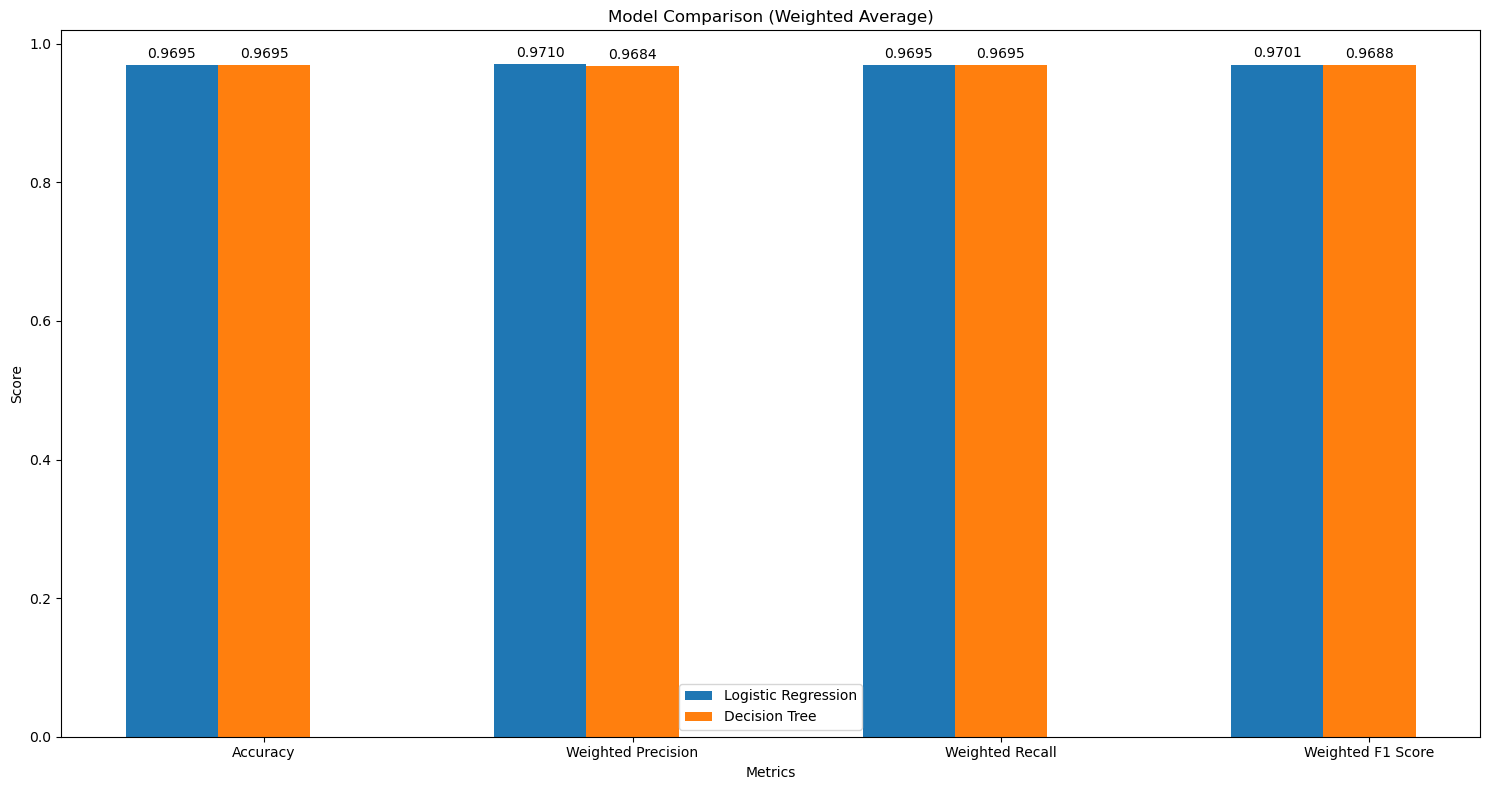

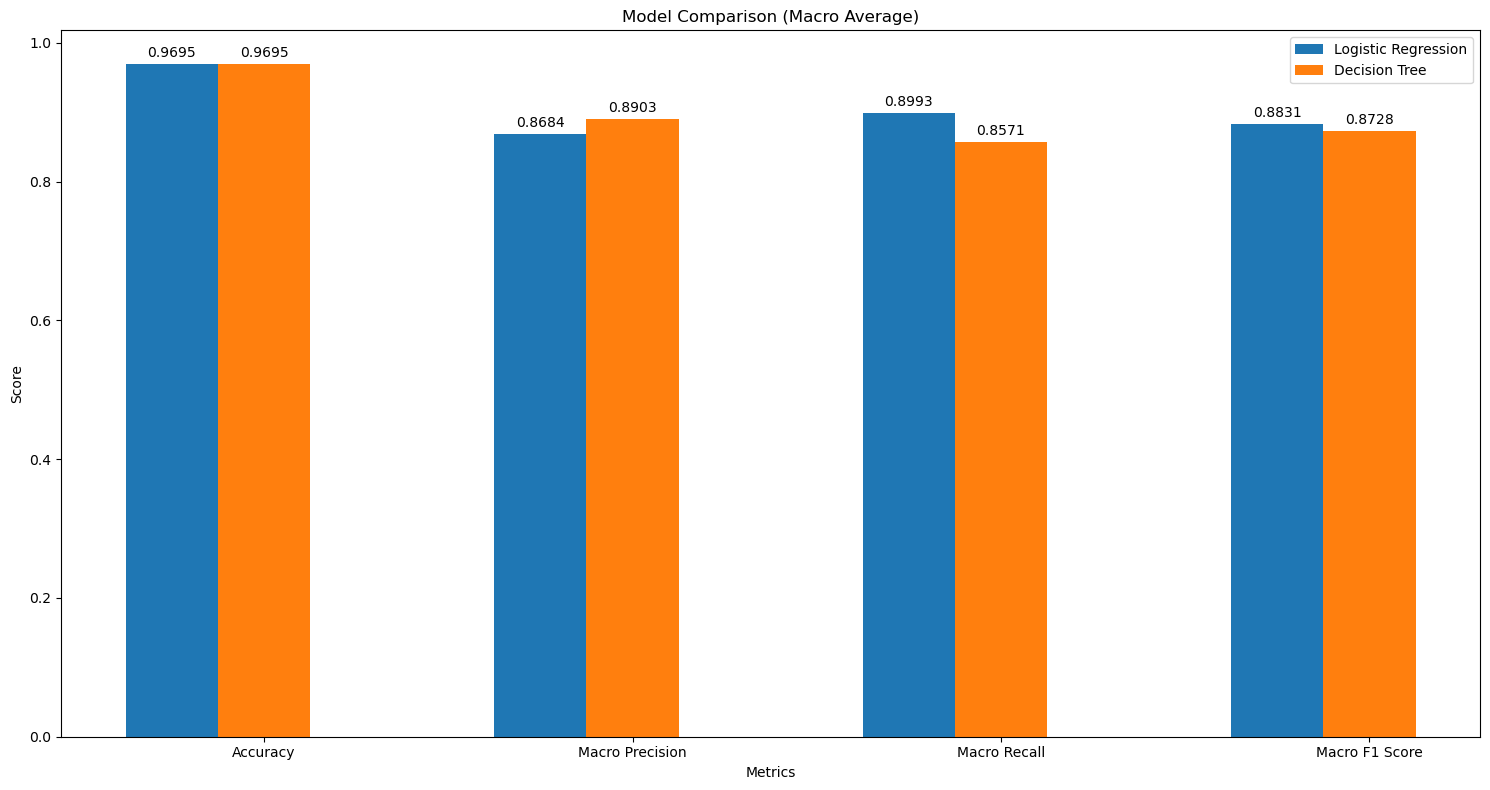


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       153
           1       0.75      0.82      0.78        11

    accuracy                           0.97       164
   macro avg       0.87      0.90      0.88       164
weighted avg       0.97      0.97      0.97       164


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       153
           1       0.80      0.73      0.76        11

    accuracy                           0.97       164
   macro avg       0.89      0.86      0.87       164
weighted avg       0.97      0.97      0.97       164



,Model,Accuracy,Macro Precision,Macro Recall,Macro F1 Score,Weighted Precision,Weighted Recall,Weighted F1 Score
0,Logistic Regression,0.969512,0.868421,0.899287,0.883108,0.970956,0.969512,0.970125
1,Decision Tree,0.969512,0.890260,0.857100,0.872809,0.968411,0.969512,0.968836


In [89]:
compare_models(
    y_true=y_test,
    model_preds=[y_pred_lr_test, y_pred_dt_test],
    model_names=["Logistic Regression", "Decision Tree"]
)